In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error
# from jours_feries_france import JoursFeries
import matplotlib.pyplot as plt
import optuna
from vacances_scolaires_france import SchoolHolidayDates

In [2]:
#holidays_2020_2021 = (
#    list(JoursFeries.for_year(2020).values()) +
#    list(JoursFeries.for_year(2021).values())
#)

# holidays_2020_2021 = pd.to_datetime(holidays_2020_2021)

In [3]:
holiday_dates = SchoolHolidayDates()

# Fetch holidays for Zone C for specific years
zone_c_holidays_2020 = holiday_dates.holidays_for_year_and_zone(2020, 'C')
zone_c_holidays_2021 = holiday_dates.holidays_for_year_and_zone(2021, 'C')

# Combine holidays for both years
all_zone_c_holidays = list(zone_c_holidays_2020.keys()) + list(zone_c_holidays_2021.keys())

# Convert to pandas datetime
all_zone_c_holidays = pd.to_datetime(all_zone_c_holidays)

In [4]:
def encode_dates(X):
    """
    Encode date information from the 'date' column.
    Adds year, month, day, weekday, hour, holiday, and weekend indicators.
    """
    lockdown_periods = [
        ("2020-03-17", "2020-05-11"),
        ("2020-10-30", "2020-12-14"),
        ("2021-04-03", "2021-06-30"),
    ]
    
    lockdown_ranges = [
        (pd.to_datetime(start), pd.to_datetime(end)) for start, end in lockdown_periods
    ]
    
    X = X.copy()
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    X["holiday"] = X["date"].isin(all_zone_c_holidays).astype(int)
    X["weekend"] = (X["date"].dt.dayofweek > 4).astype(int)
    X["lockdown"] = X["date"].apply(
        lambda d: any(start <= d <= end for start, end in lockdown_ranges)
    ).astype(int)
    X['is_peak'] = X['hour'].apply(lambda x: 1 if (6 <= x < 9 or 16 <= x < 19) else 0)

    X['sin_hour'] = np.sin(2 * np.pi * X['hour'] / 24)
    X['cos_hour'] = np.cos(2 * np.pi * X['hour'] / 24)
    
    return X.drop(columns=['date', 'hour'])

In [5]:
def engineer_weather_features(data):
    # 1. Categorical Buckets
    data['rain_category'] = pd.cut(
        data['rr1'], bins=[-1, 0, 2, 10, float('inf')],
        labels=['No Rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain']
    )
    
    data['snow_category'] = pd.cut(
        data['ht_neige'], bins=[-1, 0, 0.01, 0.05, float('inf')],
        labels=['No Snow', 'Light Snow', 'Moderate Snow', 'Heavy Snow']
    )
    
    data['is_hot_day'] = (data['t'] > 300).astype(int)  # Assuming temperature in Kelvin
    data['is_cold_day'] = (data['t'] < 283).astype(int)
    data['high_wind'] = (data['ff'] > 5).astype(int)
    
    # 3. Interaction Features
    data['rain_with_wind'] = data['rr1'] * data['ff']
    data['rolling_rain'] = data['rr1'].rolling(window=3, min_periods=1).sum()
    
    return data

In [6]:
data = pd.read_parquet(Path("data") / "train.parquet")

important_columns = ["date", "pres", "ff", "t", "u", "vv", "n", "ht_neige", "rr1"]
weather_data = pd.read_csv("./external_data/external_data.csv", usecols=important_columns)

In [7]:
weather_data["date"] = pd.to_datetime(weather_data["date"])
weather_data = weather_data.dropna(axis=1, how="all")
weather_data.set_index("date", inplace=True)
weather_data = weather_data[~weather_data.index.duplicated(keep="first")]
weather_data_interpolated = weather_data.resample("h").interpolate(method="linear")

In [8]:
merged_data = data.merge(weather_data_interpolated, on="date", how="left")

X = merged_data[["counter_name", "site_name", "date", "longitude", "latitude", "ff", "t", "u", "vv", "n", "pres", "ht_neige", "rr1"]]
y = merged_data["log_bike_count"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply date encoding

X_train_encoded2 = encode_dates(X_train)
X_test_encoded2 = encode_dates(X_test)

X_train_encoded3 = engineer_weather_features(X_train_encoded2)
X_test_encoded3 = engineer_weather_features(X_test_encoded2)

# Column transformer for preprocessing
categorical_features = ["counter_name", "site_name", "rain_category", "snow_category"]
numerical_features = list(X_train_encoded3.drop(columns=categorical_features).columns)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

In [9]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 10.0),
    }
    
    xgb_model = XGBRegressor(**params, random_state=42)
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", xgb_model)
    ])
    pipeline.fit(X_train_encoded3, y_train)
    y_pred = pipeline.predict(X_test_encoded3)
    rmse = root_mean_squared_error(y_test, y_pred)
    return rmse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)

best_params = study.best_params
best_model = XGBRegressor(**best_params, random_state=42)

xgboost_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", best_model)
])

[I 2024-12-08 21:51:33,843] A new study created in memory with name: no-name-c861fa5f-4449-450b-8be6-953bd0dcb8c7
[I 2024-12-08 21:51:40,770] Trial 0 finished with value: 0.3674283432717737 and parameters: {'n_estimators': 370, 'max_depth': 7, 'learning_rate': 0.22466180194809116, 'subsample': 0.6203691945195122, 'colsample_bytree': 0.7833505860628984, 'reg_alpha': 1.5754449495777694, 'reg_lambda': 2.327822857873093}. Best is trial 0 with value: 0.3674283432717737.
[I 2024-12-08 21:51:46,045] Trial 1 finished with value: 0.5779913518171613 and parameters: {'n_estimators': 439, 'max_depth': 4, 'learning_rate': 0.046094267052025927, 'subsample': 0.5530947593212425, 'colsample_bytree': 0.781605106660199, 'reg_alpha': 8.17212849236075, 'reg_lambda': 2.228099013753095}. Best is trial 0 with value: 0.3674283432717737.
[I 2024-12-08 21:51:51,649] Trial 2 finished with value: 0.4638436508275901 and parameters: {'n_estimators': 333, 'max_depth': 5, 'learning_rate': 0.12722028351929082, 'subsamp

Best hyperparameters: {'n_estimators': 483, 'max_depth': 10, 'learning_rate': 0.18485999909119089, 'subsample': 0.934932641877267, 'colsample_bytree': 0.771387389415114, 'reg_alpha': 7.027793583280011, 'reg_lambda': 6.210938607181354}


In [10]:
xgboost_pipeline.fit(X_train_encoded3, y_train)
y_pred = xgboost_pipeline.predict(X_test_encoded3)
final_rmse = root_mean_squared_error(y_test, y_pred)
print(f"Final XGBoost RMSE: {final_rmse:.4f}")

Final XGBoost RMSE: 0.3465


In [11]:
df_test = pd.read_parquet("./data/final_test.parquet")
df_test_merged = df_test.merge(weather_data_interpolated, on='date', how='left')
df_test_merged = df_test_merged.assign(**encode_dates(df_test_merged[["date"]]))
df_test_merged = df_test_merged.assign(**engineer_weather_features(df_test_merged))
X_test_final = df_test_merged[[
    "counter_name", "site_name", "longitude", "latitude", "ff", "t", "u", "vv", "n", "pres", "ht_neige", "rr1",
    "rain_category", "snow_category", "is_hot_day", "is_cold_day", "high_wind", "rain_with_wind", "rolling_rain",
    "year", "month", "day", "weekday", "sin_hour", "cos_hour", "is_peak", "holiday", "weekend", "lockdown"
]]
X_test_final = preprocessor.transform(X_test_final)
final_predictions = xgboost_pipeline.named_steps['model'].predict(X_test_final)

results = pd.DataFrame({"Id": np.arange(final_predictions.shape[0]), "log_bike_count": final_predictions})
results.to_csv("submission_xgboost_optuna.csv", index=False)

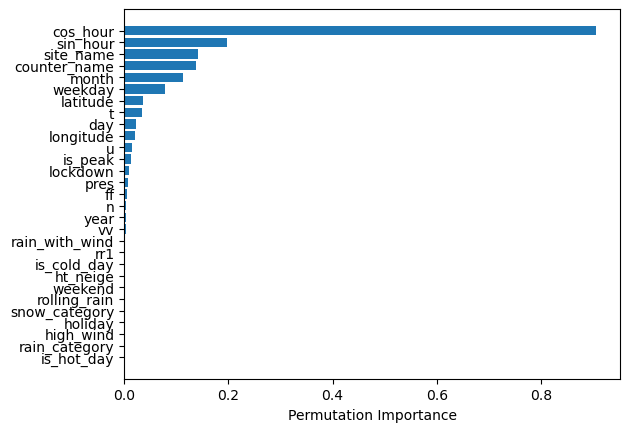

In [12]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    xgboost_pipeline, X_test_encoded3, y_test, n_repeats=10, random_state=42
)

# Visualize
sorted_idx = result.importances_mean.argsort()
plt.barh(
    X_test_encoded3.columns[sorted_idx],
    result.importances_mean[sorted_idx]
)
plt.xlabel("Permutation Importance")
plt.show()